In [3]:
from sklearn.cross_decomposition import CCA
import numpy as np
import pickle
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from scipy.spatial import procrustes
from sklearn.decomposition import PCA

import sys
sys.path.insert(0, '../SAC/')
import kinematics_preprocessing_specs

import config

parser = config.config_parser()
args, unknown = parser.parse_known_args()

In [4]:
#Load the test data of nusim

with open('../test_data/test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)
    
print(test_data.keys())

dict_keys(['emg', 'rnn_activity', 'rnn_input', 'rnn_input_fp', 'kinematics_mbodies', 'kinematics_mtargets'])


In [5]:
#Get the timepoints of each condition per cycle
with open('../kinematics_data/kinematics.pkl', 'rb') as file:
    kin_train_test = pickle.load(file)
    
kin_train = kin_train_test['train']
kin_test = kin_train_test['test']

#First update the keys of self.kin_test
for cond in range(len(kin_test)):
    kin_test[len(kin_train) + cond] = kin_test.pop(cond)
    
kin = kin_train
kin.update(kin_test)

In [6]:
print(kin[0].shape)

(1, 3, 702)


In [11]:
#Keep only dimensions that do not have NaNs
nan_conds = []
for cond in range(len(kin)):
    nan_coords = []
    for coord in range(kin[cond].shape[1]):
        if np.isnan(kin[cond][:, coord, :]).any():
            nan_coords.append(coord)
    nan_conds.append(nan_coords)
    
#Now delete the axis for which the NaNs exist
for idx, nan_cond in enumerate(nan_conds):
    dims2keep = list(range(kin[idx].shape[1]))
    for dims2rmv in nan_conds[idx]:
        dims2keep.pop(dims2rmv)
    kin[idx] = kin[idx][:, dims2keep, :]

In [13]:
print(kin[2].shape)

(1, 2, 932)


In [15]:
#Get the experimental neural data

with open('../nusim_neural_data/neural_activity_train.pkl', 'rb') as file:
    neural_train = pickle.load(file)

with open('../nusim_neural_data/neural_activity_test.pkl', 'rb') as file:
    neural_test = pickle.load(file)

#First update the keys of self.kin_test
for cond in range(len(neural_test)):
    neural_test[len(neural_train) + cond] = neural_test.pop(cond)
    
neural = neural_train
neural.update(neural_test)

In [17]:
conds = [kin[cond].shape[-1] for cond in range(len(kin))]
total_conds = len(conds)

#Select the cycle for each condition (training conditions followed by testing): 0 for 1st cycle and so on
#The number of elements should be equal to num_train_conditions + num_test_conditions
cycles = [2, 2, 2, 2, 2, 2]

#Number of fixedsteps in the start of each condition
n_fixedsteps= args.n_fixedsteps

In [19]:
#Load the network activities
A_agent = []

for idx, cond_activity in test_data['rnn_activity'].items():
    act_agent = cond_activity
    act_agent = act_agent[n_fixedsteps + cycles[idx] * conds[idx] : n_fixedsteps + (cycles[idx]+1) * conds[idx]]
    print(act_agent.shape)
    A_agent.append(act_agent[:, :])

(702, 256)
(803, 256)
(932, 256)
(1319, 256)
(619, 256)
(1106, 256)


In [21]:
# Load the experimental neural activities
A_exp = []
for cond in range(len(neural)):
    act_exp = neural[cond]
    print(act_exp.shape)
    A_exp.append(act_exp)

(702, 49)
(803, 49)
(932, 49)
(1319, 49)
(619, 49)
(1106, 49)


In [23]:
print(len(kin))
print(kin[5].shape)

6
(1, 2, 1106)


In [25]:
#Now fit the linear regression models and save the prediction matrices.
#The cond to do lra on
#Rerun the notebook (restart kernel) for every new condition here
cond = 3

for idx in range(len(conds)):
    if idx != cond:
        try:
            A_exp_lra = np.concatenate((A_exp_lra, A_exp[idx]), axis =0)
            A_agent_lra = np.concatenate((A_agent_lra, A_agent[idx]), axis =0)
            A_kin_lra = np.concatenate((A_kin_lra, kin[idx].reshape(-1, kin[idx].shape[-1]).transpose()), axis= 0)
        
        except NameError:
            A_exp_lra = A_exp[idx]
            A_agent_lra = A_agent[idx]
            A_kin_lra = kin[idx].reshape(-1, kin[idx].shape[-1]).transpose()

In [27]:
print(A_exp_lra.shape)
print(A_agent_lra.shape)
print(A_kin_lra.shape)

(4162, 49)
(4162, 256)
(4162, 2)


In [29]:
reg_net = Ridge(alpha= 5e-02).fit(A_agent_lra, A_exp_lra)

pred_net = reg_net.predict(A_agent[cond])
print(r2_score(A_exp[cond], pred_net, multioutput= 'variance_weighted'))

0.7969614011657163


In [31]:
r2_list = []

for k in range(pred_net.shape[1]):
    r_val = r2_score(A_exp[cond][:,k], pred_net[:, k])
    r2_list.append(r_val)

r2_array_net = np.array(r2_list)

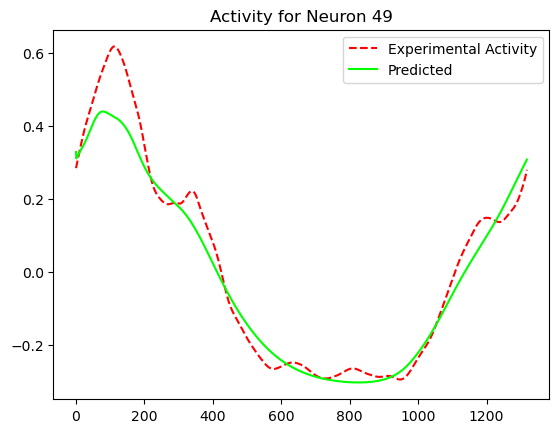

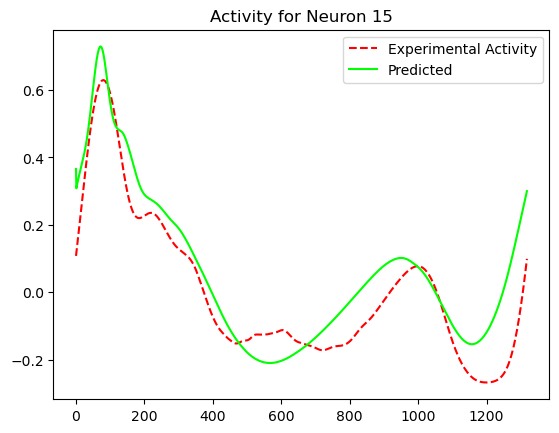

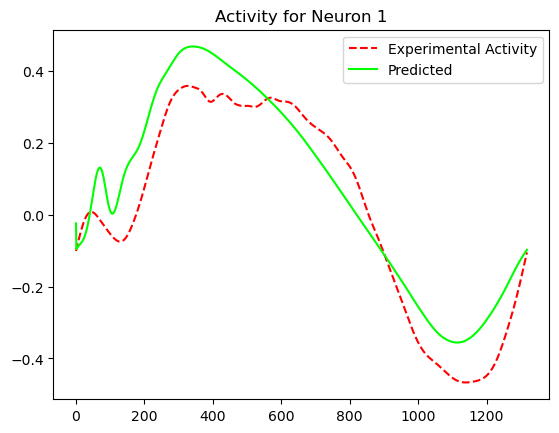

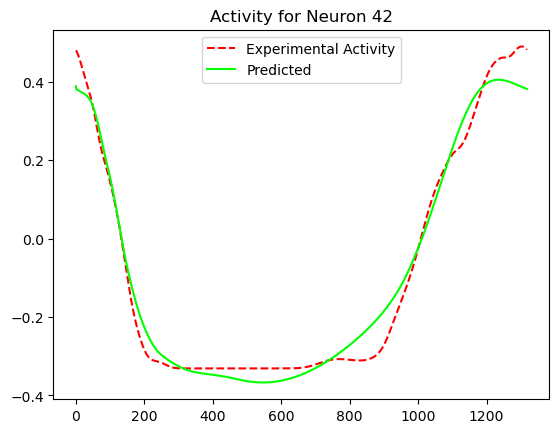

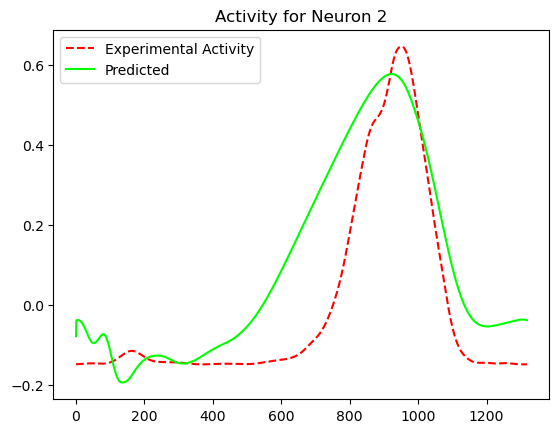

In [33]:
#Plot the neurons with highest range of activity in exp data
#Select the number of neurons to plot here
num_neurons2plot= 5

range_neurons = np.abs(np.max(A_exp[cond], axis= 0) - np.min(A_exp[cond], axis= 0))
neurons2plot = range_neurons.argsort()[-num_neurons2plot:][::-1]


for neuron2plot in neurons2plot:
    plt.plot(A_exp[cond][:, neuron2plot], '--', c= (1, 0, 0), label= 'Experimental Activity')
    plt.plot(pred_net[:, neuron2plot], '-', c = (0, 1, 0), label= 'Predicted')
    
    plt.title(f"Activity for Neuron {neuron2plot+1}")
    plt.legend()
    plt.show()

In [35]:
#Now do the comparison of reconstruction from uSim network
#against the kinematics using scatter plots

#First do the LRA using the kinematics

reg_kin = Ridge(alpha= 5e-02).fit(A_kin_lra, A_exp_lra)
pred_kin = reg_kin.predict(kin[cond].reshape(-1, kin[cond].shape[-1]).transpose())
print(r2_score(A_exp[cond], pred_kin, multioutput= 'variance_weighted'))

0.5602442041867836


In [37]:
r2_list = []

for k in range(pred_kin.shape[1]):
    r_val = r2_score(A_exp[cond][:,k], pred_kin[:, k])
    r2_list.append(r_val)

r2_array_kin = np.array(r2_list)


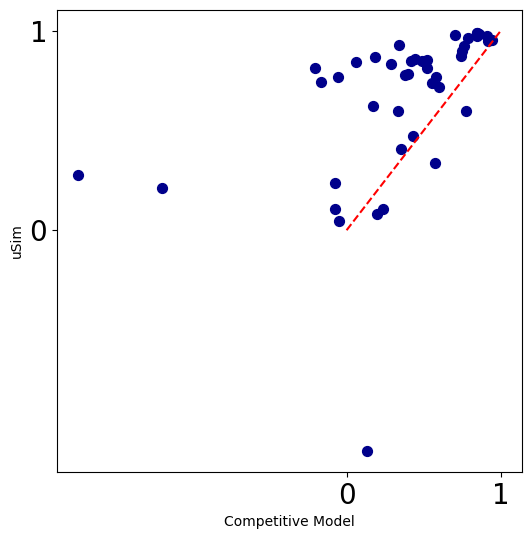

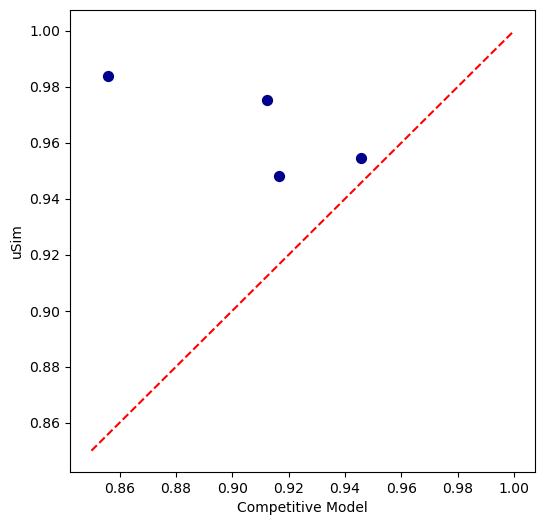

In [39]:
### ------------- Plot the scatter plot ------------------------------------------------------
filter1 = np.where(np.logical_or(r2_array_net>=0, r2_array_kin>=0))

plt.figure(figsize= (6, 6))

plt.scatter(r2_array_kin[filter1], r2_array_net[filter1], s=50, c= 'darkblue')
plt.plot([0, 1], [0, 1], '--', c= 'r', linewidth= 1.5)

plt.xticks([0, 1], ['0', '1'], size= 20)
plt.yticks([0, 1], ['0', '1'], size= 20)

plt.xlabel('Competitive Model')
plt.ylabel('uSim')

plt.show()

### ------------- Plot the scatter plot ------------------------------------------------------
filter1 = np.where(np.logical_and(r2_array_net>=0.85, r2_array_net<=1))
filter2 = np.where(np.logical_and(r2_array_kin>=0.85, r2_array_kin<=1))
filter = np.intersect1d(filter1, filter2)

plt.figure(figsize= (6, 6))

plt.scatter(r2_array_kin[filter], r2_array_net[filter], s=50, c= 'darkblue')
plt.plot([0.85, 1], [0.85, 1], '--', c= 'r', linewidth= 1.5)

plt.xlabel('Competitive Model')
plt.ylabel('uSim')

plt.show()